# Environment Setup and Version Check

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import json

# Check if the version of Python is 3.5 and above
assert sys.version_info >= (3, 5)

# Check to see if sklearn is version 0.20 and above
import sklearn
assert sklearn.__version__ >= "0.20"

# Dataset Loading and Preprocessing

In [2]:
# Load dataset and drop unnecessary columns
component = 'SiO2'  # Change component name here for different datasets
df = pd.read_excel(f"Training Dataset-LDG-1.7.xlsx", f'TEST-{component}')
df = df.drop(columns=['ID'], axis=1)
df.head()

,TI(PPM),Y(PPM),NB(PPM),LA(PPM),CE(PPM),PR(PPM),ND(PPM),SM(PPM),EU(PPM),GD(PPM),...,TH(PPM),U(PPM),TH/Y,DY/YB,NB/TH,Ce/Ce* c,Eu/Eu* c,AGE,SiO2,label
0,10.943418,358.384513,1.264139,0.013725,9.958384,0.056129,0.919617,1.667783,0.100282,6.718581,...,82.768570,178.069734,0.230949,0.257797,0.015273,87.96736,0.091588,1745.000000,43.99,1
1,71.014128,139.083887,0.422789,0.194747,1.405773,0.000000,0.630837,0.473188,0.242948,2.328459,...,34.226405,319.252984,0.246085,0.157685,0.012353,NaN,0.707596,1745.000000,43.99,1
2,4.281921,221.320334,0.325317,0.027153,0.636933,0.000000,0.173986,0.395888,0.261092,2.988061,...,29.959334,274.037885,0.135366,0.112501,0.010859,NaN,0.733899,1745.000000,43.99,1
3,NaN,NaN,NaN,NaN,9.229424,NaN,1.083306,2.587806,0.913558,23.427200,...,145.007866,313.757871,NaN,NaN,0.000000,NaN,0.358702,249.024812,44.85,1
4,NaN,NaN,NaN,NaN,3.589213,NaN,0.707841,1.602787,0.529098,11.321334,...,37.012808,107.183761,NaN,NaN,0.000000,NaN,0.379729,254.733356,44.85,1


In [3]:
# Prepare features and labels
X = df.drop([component, 'label'], axis=1)
y = df[component]

# Stratified random sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=99)
for train_index, test_index in split.split(df, df["label"]):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]


In [ ]:
# Create an instance of the XGBoost regressor
xgb_model = xgb.XGBRegressor()

# Define the hyperparameter grid
params = {
    "colsample_bytree": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "booster": ["gblinear", "gbtree"],
    "max_depth": np.arange(2, 20, 1),
    "learning_rate": np.arange(0.03, 0.2, 0.01),
    "min_child_weight": np.arange(40, 300, 10),
    "n_estimators": np.arange(100, 800, 20),
    "base_score": np.arange(0, 0.6, 0.05)
}

# Hyperparameter tuning using RandomizedSearchCV
xgb_opt = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=params,
    cv=10,
    scoring='r2',
    n_jobs=-1,
    n_iter=50,
    random_state=100
)
xgb_opt.fit(X_train, y_train)

# Calling the optimized hyperparameters and model training

In [4]:
# Load hyperparameters from JSON file
with open('hyperparameters.json', 'r') as f:
    hyperparameters = json.load(f)

# Train the model for a specific component (e.g., SiO2)
xgb_reg = xgb.XGBRegressor(
    **hyperparameters[component],
    objective='reg:squarederror',
    n_jobs=-1,
    verbosity=1
)
xgb_reg.fit(X_train, y_train)

# Ten-fold-cross validation

In [10]:
# Ten-fold cross-validation results
results = cross_val_score(xgb_reg, X_train, y_train, scoring='r2', cv=10)
print("Cross-validation results:", results)

Cross-validation results: [0.74181142 0.77335866 0.78078854 0.7831271  0.78981995 0.80075021
 0.78942043 0.76597337 0.77107637 0.77601063]


In [9]:
# Ten-fold cross-validation results
kfold = KFold(n_splits=10, shuffle=True, random_state=99)
results = cross_val_score(xgb_reg, X_train, y_train, scoring='r2', cv=kfold)
print("Cross-validation results:", results)

Cross-validation results: [0.75299523 0.77684316 0.77548783 0.76584349 0.77548445 0.79344164
 0.77238518 0.74951157 0.80466207 0.76888921]


The absolute error for the XGBOOST Model : 2.7025038906962373
The mean squared error for the XGBOOST Model : 3.7733960695307904
The R2-score for the XGBOOST Model : 0.8003030748283555


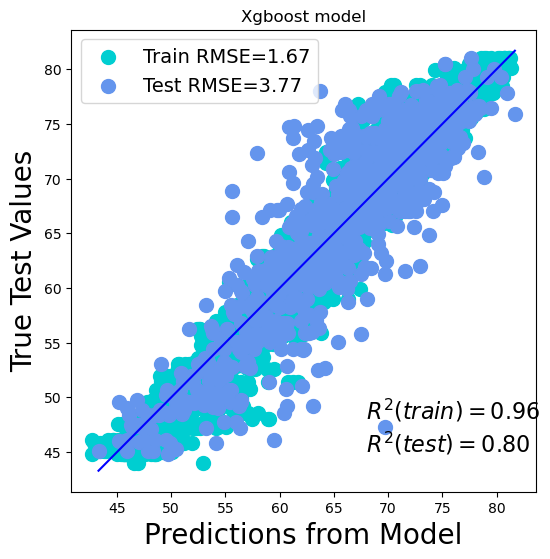

In [5]:
# Make predictions
y_xgb = xgb_reg.predict(X_test)
y_xgb_train = xgb_reg.predict(X_train)

# Evaluate the model
MAE = mean_absolute_error(y_test, y_xgb)
RMSE = np.sqrt(mean_squared_error(y_test, y_xgb))
R2_xg = r2_score(y_test, y_xgb)

MAE2 = mean_absolute_error(y_train, y_xgb_train)
RMSE2 = np.sqrt(mean_squared_error(y_train, y_xgb_train))
R2_xg2 = r2_score(y_train, y_xgb_train)

print("The absolute error for the XGBOOST Model :", MAE)
print("The mean squared error for the XGBOOST Model :", RMSE)
print("The R2-score for the XGBOOST Model :", R2_xg)

# Plot results
plt.figure(figsize=(6, 6))
p1 = max(max(y_xgb), max(y_test))
p2 = min(min(y_xgb), min(y_test))
plt.plot([p1, p2], [p1, p2], 'blue')
plt.ylabel('True Test Values', fontsize=20)
plt.xlabel('Predictions from Model', fontsize=20)
text_position = [68, 50]

plt.scatter(y_xgb_train, y_train, s=100, marker="o", c='DarkTurquoise', alpha=1, label="Train RMSE={:.2f}".format(RMSE2))
plt.scatter(y_xgb, y_test, s=100, marker="o", c='cornflowerblue', alpha=1, label="Test RMSE={:.2f}".format(RMSE))

plt.legend(loc="upper left", fontsize=14)
plt.text(text_position[0], text_position[1] - 5, r'$R^2(test)=${:.2f}'.format(R2_xg), fontdict={'size': 16, 'color': '#000000'})
plt.text(text_position[0], text_position[1] - 2, r'$R^2(train)=${:.2f}'.format(R2_xg2), fontdict={'size': 16, 'color': '#000000'})

plt.title('Xgboost model')
#plt.savefig(f"Xgboost model-{component}.svg", format='svg')  # Save the plot with the component name for easy identification
plt.show()

# Model export and saving.

In [ ]:
# Save the trained model
with open(f'D://Jupyter//Zircon ML-XGBOOST//Zircon Models//Zircon ML-XGBOOST-{component}.pkl', 'wb') as f:  # Save the model with the component name for easy identification
    pickle.dump(xgb_reg, f)

# Model feature importance and results of the 1000-time distribution.

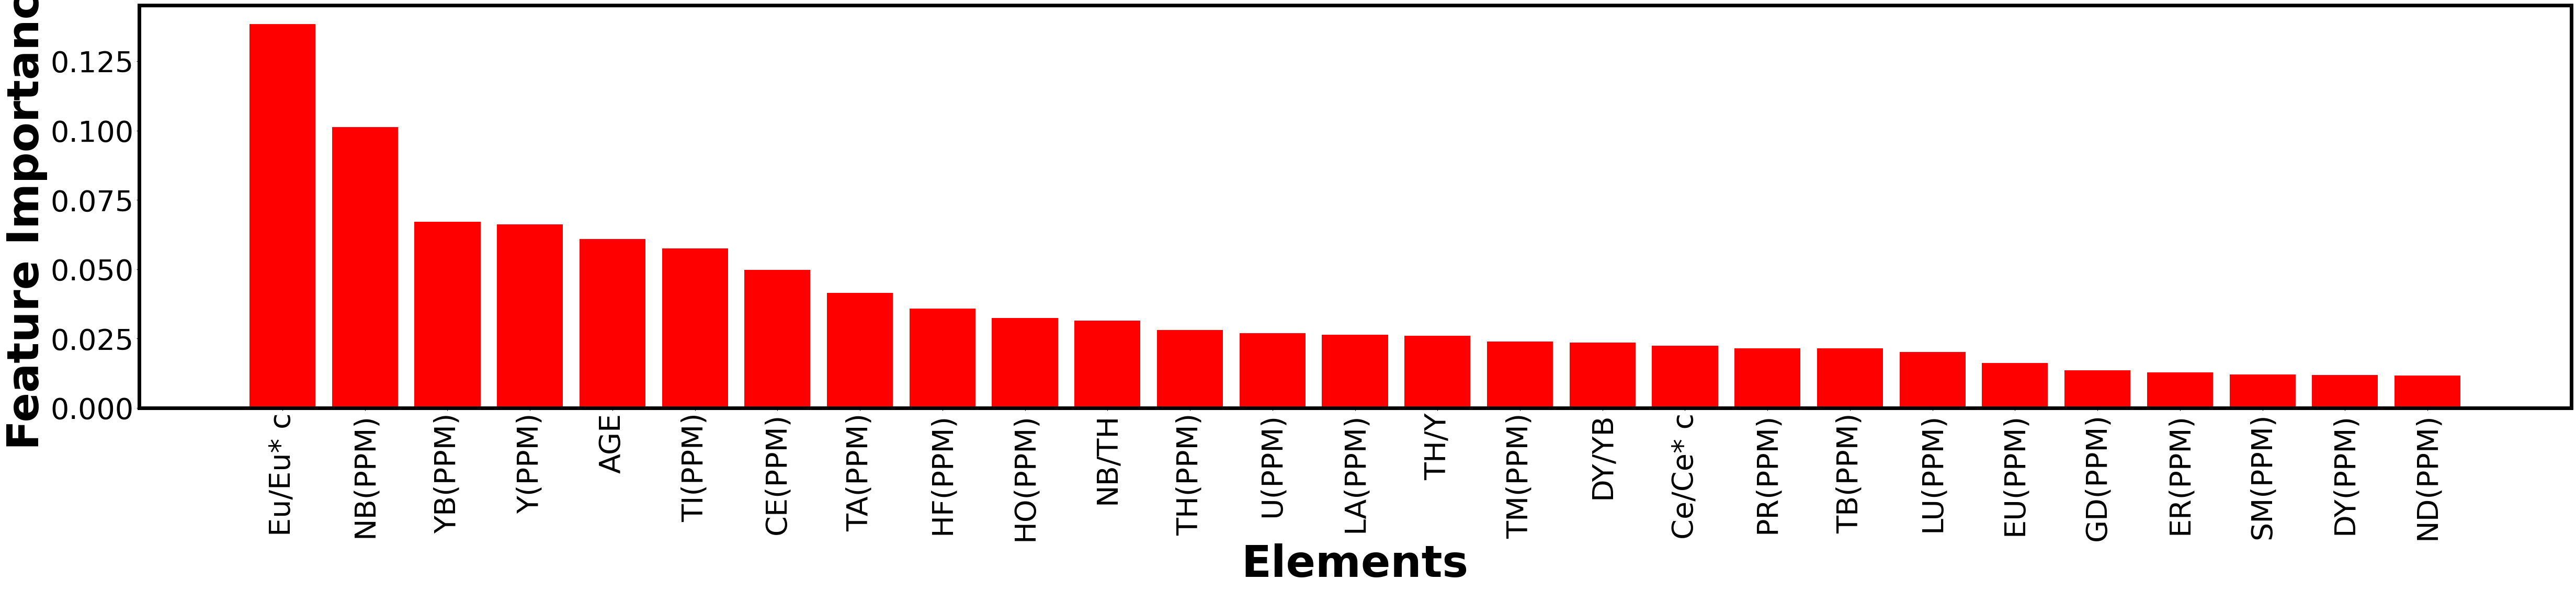

In [6]:
# Feature importance plot
columns = list(df.columns[:27])

# Check the length of the features and truncate if necessary
importances = xgb_reg.feature_importances_[:len(columns)]

c = {"feature": columns, "importance": importances}
df_importance = pd.DataFrame(c)
df_importance = df_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(60, 10))
# Bar chart showing the feature importance of xgBOOST predictions
plt.bar(range(len(df_importance)), df_importance['importance'], tick_label=df_importance['feature'], color='r')

plt.tick_params(labelsize=40)
plt.xticks(rotation=90)
plt.ylabel('Feature Importance', fontsize=60, fontweight='bold')
plt.xlabel('Elements', fontsize=60, fontweight='bold')
plt.grid(False)
ax = plt.gca()

for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(5)

ax.yaxis.set_ticks_position('left')

#plt.savefig(f"rnd_feature_importance_{component}.svg", format='svg')  # Save feature importance plot with the component name
plt.show()


In [11]:
# 1000-times Monte Carlo Cross Validation result
list11 = []
repeat = 1000
for i in range(0, repeat):
    # stratified random sampling based on the results of KMeans Clustering
    split_xgb = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=None)
    # divide augmented X and y into training and testing data
    for train_index, test_index in split_xgb.split(df, df["label"]):
        X_train = X.loc[train_index]
        X_test = X.loc[test_index]
        y_train = y.loc[train_index]
        y_test = y.loc[test_index]
    
    # Use the selected component's hyperparameters
    model_xgb = xgb.XGBRegressor(
        **hyperparameters[component],
        objective='reg:squarederror',
        n_jobs=-1,
        verbosity=1
    )
    model_xgb.fit(X_train, y_train)
    
    predict_train = model_xgb.predict(X_train)
    predict_test = model_xgb.predict(X_test)
    
    list11.append(r2_score(y_test, predict_test))
    
df11 = pd.DataFrame(list11)

# Save the excel if needed
# Output and save the MC predicted testing data results
#df11.to_excel(f"{component}_r2.xlsx") 

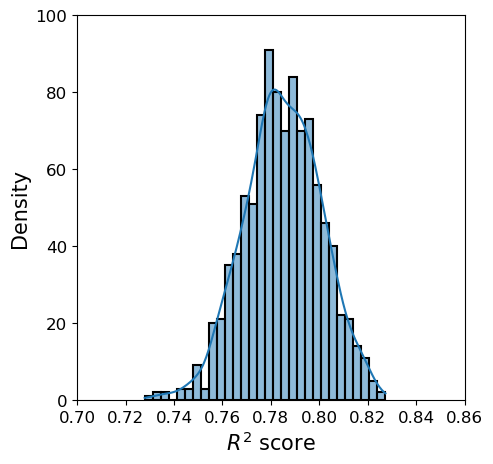

In [19]:
# Visualization

plt.figure(figsize=(5,5), dpi=100)

# Create histogram with optimized parameters
ax1 = plt.subplot(111)
ax1 = sns.histplot(df11, bins=30, color='green', kde=True, edgecolor='black', linewidth=1.5, line_kws={'color': 'black'}, legend=False)

# Set axis limits and labels
ax1.set_xlim((0.70, 0.86))
ax1.set_ylim((0, 100))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax1.set_ylabel('Density', fontsize=15)
ax1.set_xlabel('$R^{2}$ score', fontsize=15)

# Save the figure if needed
# plt.savefig(f"Xgboost_zircon_ML_R2-{component}.svg", format='svg', dpi=600)
plt.show()
